# Exercise 1. FCN implementation

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.nn as nn
import os.path as osp
import PIL

In [2]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

print(device)

cpu


In [3]:
print(torch.cuda.is_available())

False


### Unzip Dataset

In [4]:
!unzip Kitti.zip -d ./data/Kitti

Archive:  Kitti.zip
checkdir:  cannot create extraction directory: ./data/Kitti
           No such file or directory


파일을 제대로 다운로드 하였고 읽을 수 있는지 확인해봅니다.

In [6]:
imgsets_file = osp.join('/home/piai/AI/3week/segmentation/Kitti', '{}.txt'.format('train'))
for line in open(imgsets_file):
    line = line.strip()
    print(line)
    line = line.split()

training/image_2/um_000000.png training/gt_image_2/um_road_000000.png
training/image_2/um_000001.png training/gt_image_2/um_road_000001.png
training/image_2/um_000002.png training/gt_image_2/um_road_000002.png
training/image_2/um_000003.png training/gt_image_2/um_road_000003.png
training/image_2/um_000004.png training/gt_image_2/um_road_000004.png
training/image_2/um_000005.png training/gt_image_2/um_road_000005.png
training/image_2/um_000006.png training/gt_image_2/um_road_000006.png
training/image_2/um_000007.png training/gt_image_2/um_road_000007.png
training/image_2/um_000008.png training/gt_image_2/um_road_000008.png
training/image_2/um_000009.png training/gt_image_2/um_road_000009.png
training/image_2/um_000010.png training/gt_image_2/um_road_000010.png
training/image_2/um_000011.png training/gt_image_2/um_road_000011.png
training/image_2/um_000012.png training/gt_image_2/um_road_000012.png
training/image_2/um_000013.png training/gt_image_2/um_road_000013.png
training/image_2/um_

## Dataset & Dataloader

In [8]:
class KITTIdataset(torch.utils.data.Dataset):
    class_names = np.array(['background', 'road'])

    def __init__(self, root, transform, split='train'):
        self.root = root
        self.split = split
        self.transform = transform

        self.image_path = []
        self.ys = []
        
        imgsets_file = osp.join(root, '{}.txt'.format(split))
        for did in open(imgsets_file):
            did = did.strip()
            did = did.split()
            img_file = osp.join(root, 'data_road/{}'.format(did[0]))
            lbl_file = osp.join(root, 'data_road/{}'.format(did[1]))
            self.image_path.append(img_file)
            self.ys.append(lbl_file)

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, index):
        # load image
        img_file = self.image_path[index]
        img = PIL.Image.open(img_file)
        
        # load label
        lbl_file = self.ys[index]
        lbl = PIL.Image.open(lbl_file)
        lbl = np.array(lbl)
        lbl[lbl == 255] = 1 # 0 is black 255 is white
        
        return self.transform(img), torch.from_numpy(lbl).long()

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
train_dataset = KITTIdataset(root = '/home/piai/AI/3week/segmentation/Kitti', split = 'train', transform = transform)
val_dataset = KITTIdataset(root = '/home/piai/AI/3week/segmentation/Kitti', split = 'val', transform = transform)

In [10]:
print(len(train_dataset), len(val_dataset))
print(len(train_dataset[0]))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

241 48
2
torch.Size([3, 375, 1242]) torch.Size([375, 1242])


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle = False)

## Evaluation matric (mIoU)

The evaluation matric code is given.  

In [13]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class**2).reshape(n_class, n_class)
    return hist

def compute_mean_iou(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iou = np.nanmean(iu)
    
    return mean_iou

# Define the Network

- FCN model

In [54]:
class FCN(nn.Module):
    def __init__(self, num_class=3):
        super(FCN, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.num_class = num_class
    
        #############################################################
        # Structure of the FCN model
        #
        #   3 ->   64 2
        #  64 ->  128 2
        # 128 ->  256 3 conv->relu->conv->relu->conv->relu => Predict 3
        # 256 ->  512 3 conv->relu->conv->relu->conv->relu => Predict 2
        # 512 ->  512 3 conv->relu->conv->relu->conv->relu
        # 512 -> 4096 2 conv->relu->conv->relu => Predict 1
        
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
        #############################################################
        
        ## conv1
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 100), # the padding=100 is given for a reason! Other conv2d should all have padding=1
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding =1),
            nn.ReLU())
        
        ## conv2
        self.features2 = nn.Sequential( ## implement code here
            nn.Conv2d(64, 128, 3, padding = 1), # the padding=100 is given for a reason! Other conv2d should all have padding=1
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding =1),
            nn.ReLU())
            
        ## conv3
        self.features3 = nn.Sequential( ## implement code here
            nn.Conv2d(128, 256, 3, padding = 1), # the padding=100 is given for a reason! Other conv2d should all have padding=1
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding =1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding =1))
        ## conv4
        self.features4 = nn.Sequential( ## implement code here
            nn.Conv2d(256, 512, 3, padding = 1), # the padding=100 is given for a reason! Other conv2d should all have padding=1
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding =1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding =1))
        ## conv5
        self.features5 = nn.Sequential( ## implement code here
            nn.Conv2d(512, 512, 3, padding = 1), # the padding=100 is given for a reason! Other conv2d should all have padding=1
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding =1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding =1))
        ## maxpool
        self.maxpool = nn.MaxPool2d(2, stride = 2, ceil_mode = True)
        
        #4096->4096->num_class
        self.classifier = nn.Sequential( # conv(kernel_size=7) - relu - dropout - conv(kernel_size=1) - relu - dropout - conv(kernel_size=1)
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(4096, self.num_class, 1))
        ## upsampling transposed convolution (use nn.ConvTranspose2d, in&out channel:num_class)
        self.upscore2 = nn.ConvTranspose2d(self.num_class, self.num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore4 = nn.ConvTranspose2d(self.num_class, self.num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore8 = nn.ConvTranspose2d(self.num_class, self.num_class, kernel_size = 16, stride = 8, bias = False)
        
        self.score_pool4 = nn.Conv2d(512, self.num_class, 1)
        self.score_pool3 = nn.Conv2d(256, self.num_class, 1)

        self.softmax = nn.Softmax2d()

        
    def forward(self, x):
        #################################
        ## implement code here
        ## Exercise 1에 나온 모델 구조 그림을 참고하세요.

        x1 = self.features1(x)
        pool1 = self.maxpool(x1)

        x2 = self.features2(pool1)
        pool2 = self.maxpool(x2)

        x3 = self.features3(pool2)
        pool3 = self.maxpool(x3)

        x4 = self.features4(pool3)
        pool4 = self.maxpool(x4)

        x5 = self.features5(pool4)
        pool5 = self.maxpool(x5)

        predict1 = self.classifier(pool5)
    
        deconv1 = self.upscore2(predict1)
        predict2 = self.score_pool4(pool4)
        predict2 = predict2[:, :, 5:5 + deconv1.size()[2], 5:5 + deconv1.size()[3]] # 사이즈 조절을 위함
        add1 = torch.add(deconv1, predict2)

        deconv2 = self.upscore4(add1)
        predict3 = self.score_pool3(pool3)
        predict3 = predict3[:, :, 9:9 + deconv2.size()[2], 9:9 + deconv2.size()[3]] # 사이즈 조절을 위함
        add2 = torch.add(deconv2, predict3)


        deconv3 = self.upscore8(add2)
        out = deconv3[:, :, 33:33 + x.size()[2], 33:33 + x.size()[3]] # 사이즈 조절을 위함
        
        out = self.softmax(out)
        ##################################

        return out

In [55]:
model = FCN(num_class = 2)

In [56]:
criterion = nn.CrossEntropyLoss()

In [57]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 1e-4)

In [58]:
training_epochs = 2
best_iou = 0
num_class = len(train_loader.dataset.class_names)

In [59]:
for epoch in range(training_epochs):
    " Training "
    model.train()
    print ('current epoch : %d'%(epoch))
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        ## implement code here # clears old gradients from the last step
        optimizer.zero_grad()
        ## implement code here # output
        score = model(data)
        ## implement code here # loss
        loss = criterion(score, target)
        ## implement code here # computes the derivative of the loss w.r.t. the parameters using backpropagation
        loss.backward()
        ## implement code here # causes the optimizer to take a step based on the gradients of the parameters
        optimizer.step()
        
        if batch_idx % 20 ==0:
            print ('batch : {}, loss : {}'.format(batch_idx, loss.item()))

        
    " Validation "
    model.eval()
    val_loss = 0
    metrics = []
    with torch.no_grad(): # Gradient calculation X
        for batch_idx, (data, target) in enumerate(val_loader):
            score = model(data)

            loss = criterion(score, target)
            
            val_loss += loss.item()

            _, lbl_pred = score.max(1)
            lbl_pred = lbl_pred.cpu().numpy()  
            lbl_true = target.cpu().numpy()

            for lt, lp in zip(lbl_true, lbl_pred): # lbl_true, lbl_pred: [batch, h, w]
                tmp = compute_mean_iou(lt, lp, num_class)
                metrics.append(tmp)
    
    val_loss /= len(val_loader)
    metrics = np.mean(metrics)
    
    print ('val loss : {}, mean_iou : {}'.format(val_loss, metrics))

    # save model
    if best_iou < metrics:
        best_iou = metrics
        print("Best model saved")
        torch.save(model.state_dict(), './model_best.pth')
    
print('Finished Training')

current epoch : 0
batch : 0, loss : 0.6930838823318481
batch : 20, loss : 0.6930009126663208
batch : 40, loss : 0.6929371356964111
batch : 60, loss : 0.6926605701446533
batch : 80, loss : 0.6913859248161316
batch : 100, loss : 0.6845242977142334
batch : 120, loss : 0.6597262620925903
batch : 140, loss : 0.6338916420936584
batch : 160, loss : 0.6303837299346924
batch : 180, loss : 0.631036639213562
batch : 200, loss : 0.5877617001533508
batch : 220, loss : 0.6265297532081604
batch : 240, loss : 0.5740227699279785
val loss : 0.5911813452839851, mean_iou : 0.3895526323871082
Best model saved
current epoch : 1
batch : 0, loss : 0.5966984033584595
batch : 20, loss : 0.5736820697784424
batch : 40, loss : 0.5495851039886475
batch : 60, loss : 0.5298347473144531
batch : 80, loss : 0.5457468628883362
batch : 100, loss : 0.48934677243232727
batch : 120, loss : 0.5023321509361267
batch : 140, loss : 0.6107619404792786
batch : 160, loss : 0.5014520883560181
batch : 180, loss : 0.4910428524017334
b

# Exercise 2. U-Net implementation

In [60]:
class UNet(nn.Module):
    def __init__(self, num_class=3):
        super(UNet, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.num_class = num_class

        ##################################################
        # 자유롭게 U-Net 구조를 만들어보세요.
        # 24_Segmentation.pdf 파일의 Exercise 2. U-Net implementation 설명 figure를 참고하셔도 좋습니다.
        # 간소한 버전으로 구현을 하고, 최대한 skip-connection을 사용하는 방법을 생각해보세요.
        
        # self.@@@ = nn.@@@@
        # ...


        ##################################################
        self.down_layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(64))
        
        self.down_layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(128))
        
        self.down_layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(256))
        
        self.pool_layer = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.mid_layer = nn.Sequential(nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(256))
        
        self.up_layer1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1,
                                                         output_padding = 1),
                                                         nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                                                         nn.ReLU(),
                                                         nn.BatchNorm2d(256))
                                       
        self.up_layer2 = nn.Sequential(nn.ConvTranspose2d(512, 128, kernel_size = 3, stride = 2, padding = 1,
                                                         output_padding = 1),
                                                         nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                                                         nn.ReLU(),
                                                         nn.BatchNorm2d(256))
                                       
        self.up_layer3 = nn.Sequential(nn.ConvTranspose2d(384, 128, kernel_size = 3, stride = 2, padding = 1,
                                                         output_padding = 1),
                                                         nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                                                         nn.ReLU(),
                                                         nn.BatchNorm2d(256))
                                       
        self.score_layer = nn.Conv2d(256, self.num_class, 1)
        self.softmax = nn.Softmax2d()
                                       
    def forward(self, x):
        ##################################################
        # 자유롭게 U-Net 구조를 만들어보세요.
        # 24_Segmentation.pdf 파일의 Exercise 2. U-Net implementation 설명 figure를 참고하셔도 좋습니다.
        # 간소한 버전으로 구현을 하고, 최대한 skip-connection을 사용하는 방법을 생각해보세요.
        
        # x1 = self.@@@(x)
        # ...


        ##################################################
        x = self.down_layer1(x)
        x1 = self.pool_layer(x)
        x1 = self.down_layer2(x1)
        x2 = self.pool_layer(x1)
        x2 = self.down_layer3(x2)
        x3 = self.pool_layer(x2)
        
        x4 = self.mid_layer(x3)
                                
        x5 = self.up_layer1(x4)
        x6 = self.up_layer2(torch.cat((x5, x2), dim = 1))
        x7 = self.up_layer3(torch.cat((x6, x1), dim = 1))
        
        out = self.score_layer(x7)
                    
        out = self.softmax(out)
                                       
        return out

UNet 코드는 실행되지 않아도 좋습니다. U-Net 구조와 Skip-connection의 활용법을 배우는 것이 목표입니다.  
(UNet 코드의 경우 데이터의 사이즈 문제 등으로 그대로 실행시 돌아가지 않을 가능성이 큽니다.)

# Exercise 3. Pretrained Model

In [63]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import matplotlib.pyplot as plt

In [64]:
# Load the DeepLabV3
model = deeplabv3_resnet101(pretrained=True)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [65]:
# Load image
image_path = '/home/piai/AI/3week/segmentation/cat.jpg'  # 사용할 이미지 파일 경로
image = Image.open(image_path).convert("RGB")

In [66]:
# Preprocess image
def crop_to_square(image):
    h, w = image.size
    new_size = min(h, w)
    
    # Calculate the cropping box
    left = (w - new_size) / 2
    top = (h - new_size) / 2
    right = (w + new_size) / 2
    bottom = (h + new_size) / 2
    
    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))
    
    return cropped_image

preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = crop_to_square(image)
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가

In [67]:
# Inference
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

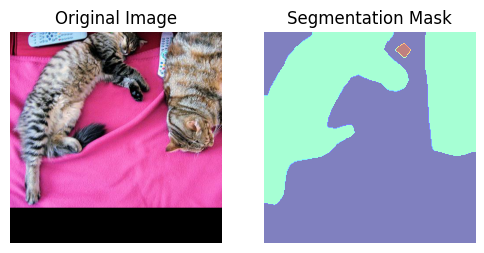

In [68]:
# Visualization
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output_predictions.cpu().numpy(), cmap="jet", alpha=0.5)
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()